# LSTM - Time Serise Dataset

* 서울시 기후 데이터 : 2011년 01월 01일 ~ 2019년 12월 31일
* https://data.kma.go.kr/cmmn/main.do
* 기후통계분석 -> 기온분석 -> 기간(20110101~20191231) -> 검색 -> CSV 다운로드
* Seoul_Temp.csv

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import Packages

* Packages

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# 1. Colab File Upload

> ## 1) 'Seoul_Temp.csv' 파일을 Colab에 업로드 후 진행

In [3]:
url = 'https://raw.githubusercontent.com/rusita-ai/pyData/master/Seoul_Temp.csv'
temp = pd.read_csv(url)

temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3287 non-null   object 
 1   avg     3287 non-null   float64
 2   min     3287 non-null   float64
 3   max     3287 non-null   float64
dtypes: float64(3), object(1)
memory usage: 102.8+ KB


In [4]:
temp.head()

,date,avg,min,max
0,2011-01-01,-6.8,-10.4,-2.9
1,2011-01-02,-5.4,-8.5,-1.2
2,2011-01-03,-4.5,-8.5,-0.3
3,2011-01-04,-3.9,-7.4,-1.7
4,2011-01-05,-4.0,-7.7,-1.8


In [5]:
temp.tail()

,date,avg,min,max
3282,2019-12-27,-1.7,-4.6,2.6
3283,2019-12-28,1.1,-3.6,6.1
3284,2019-12-29,3.8,1.1,6.2
3285,2019-12-30,2.7,-5.7,6.8
3286,2019-12-31,-7.9,-10.9,-4.5


# 2. Data Preprocessing

> ## 1) 일일 평균온도('avg') 변화 시각화

* 일일 평균온도 변화에 일정한 패턴 확인

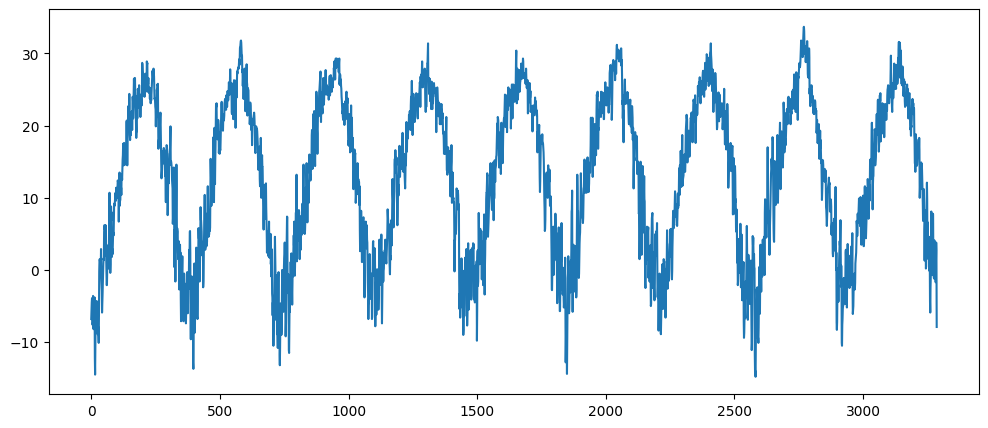

In [6]:
temp_data = temp[['avg']]

plt.figure(figsize = (12, 5))
plt.plot(temp_data)
plt.show()

> ## 2) Normalization

* tanh Activation 적용을 위해 -1 ~ 1 범위로 정규화

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

temp_data = scaler.fit_transform(temp_data)

> ## 3) Train vs. Test Split
- 시간의 순서가 중요하므로 random split하면 안됨(싸이킷런 함수)
* Train_Dataset : 2011년 01월 01일 ~ 2017년 12월 31일
* Test_Dataset : 2018년 01월 01일 ~ 2019년 12월 31일

In [8]:
train = temp_data[0:2557]
test  = temp_data[2557:]

In [9]:
train

array([[-0.67010309],
       [-0.61237113],
       [-0.57525773],
       ...,
       [-0.30309278],
       [-0.33195876],
       [-0.40206186]])

# 3. 시계열 데이터 처리 함수

> ## 1) 시계열 학습용 데이터 생성 함수 정의

* X : 학습 평균온도 데이터
* y : 정답 평균온도 데이터
* 일정 기간의 X로 y를 예측하도록 학습
* 예를 들어, look_back이 2일 때, time_data가 [1, 2, 3, 4, 5]라면, data_X는 [[1, 2], [2, 3], [3, 4]]가 되고, data_y는 [3, 4, 5]가 됩니다.

In [10]:
def create_dataset(time_data, look_back = 1):
    data_X, data_y = [], []

    for i in range(len(time_data) - look_back):
        data_X.append(time_data[i:(i + look_back), 0])
        data_y.append(time_data[i + look_back, 0])

    return np.array(data_X), np.array(data_y)

> ## 2) loop_back 기간 설정 후 학습데이터 생성

* 180일 기간 평균온도로 다음날 평균온도 예측 데이터 생성

In [11]:
look_back = 180

train_X, train_y = create_dataset(train, look_back)
test_X,  test_y  = create_dataset(test, look_back)

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180), (2377,), (550, 180), (550,))

In [12]:
train_X

array([[-0.67010309, -0.61237113, -0.57525773, ...,  0.40206186,
         0.60412371,  0.47628866],
       [-0.61237113, -0.57525773, -0.55051546, ...,  0.60412371,
         0.47628866,  0.59175258],
       [-0.57525773, -0.55051546, -0.55463918, ...,  0.47628866,
         0.59175258,  0.64536082],
       ...,
       [ 0.61237113,  0.62886598,  0.71134021, ..., -0.54639175,
        -0.6742268 , -0.47628866],
       [ 0.62886598,  0.71134021,  0.74020619, ..., -0.6742268 ,
        -0.47628866, -0.30309278],
       [ 0.71134021,  0.74020619,  0.74845361, ..., -0.47628866,
        -0.30309278, -0.33195876]])

In [13]:
train_y

array([ 0.59175258,  0.64536082,  0.62886598, ..., -0.30309278,
       -0.33195876, -0.40206186])

> ## 3) Tensor Reshape

In [14]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180, 1), (2377,), (550, 180, 1), (550,))

# 4. LSTM

> ## 1) Model Define

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential(name = 'LSTM')
model.add(LSTM(128,
               input_shape = (None, 1)))

model.add(Dense(1, activation = 'tanh'))

* Model Summary

In [16]:
model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


> ## 2) Model Compile

In [17]:
model.compile(loss = 'mse',
              optimizer = 'adam',
              metrics = ['mae'])

> ## 3) Model Fit

* 약 6분

In [18]:
%%time

hist = model.fit(train_X, train_y,
                 epochs = 100,
                 batch_size = 16,
                 validation_data = (test_X, test_y))

Epoch 1/100
149/149 [==============================] - 6s 15ms/step - loss: 0.0261 - mae: 0.1167 - val_loss: 0.0154 - val_mae: 0.0952
Epoch 2/100
149/149 [==============================] - 1s 10ms/step - loss: 0.0166 - mae: 0.0980 - val_loss: 0.0132 - val_mae: 0.0892
Epoch 3/100
149/149 [==============================] - 1s 10ms/step - loss: 0.0145 - mae: 0.0927 - val_loss: 0.0119 - val_mae: 0.0847
Epoch 4/100
149/149 [==============================] - 1s 10ms/step - loss: 0.0126 - mae: 0.0857 - val_loss: 0.0105 - val_mae: 0.0800
Epoch 5/100
149/149 [==============================] - 1s 9ms/step - loss: 0.0110 - mae: 0.0797 - val_loss: 0.0094 - val_mae: 0.0738
Epoch 6/100
149/149 [==============================] - 1s 9ms/step - loss: 0.0099 - mae: 0.0756 - val_loss: 0.0086 - val_mae: 0.0723
Epoch 7/100
149/149 [==============================] - 1s 9ms/step - loss: 0.0091 - mae: 0.0725 - val_loss: 0.0089 - val_mae: 0.0745
Epoch 8/100
149/149 [==============================] - 2s 13ms/st

> ## 4) 학습결과 시각화

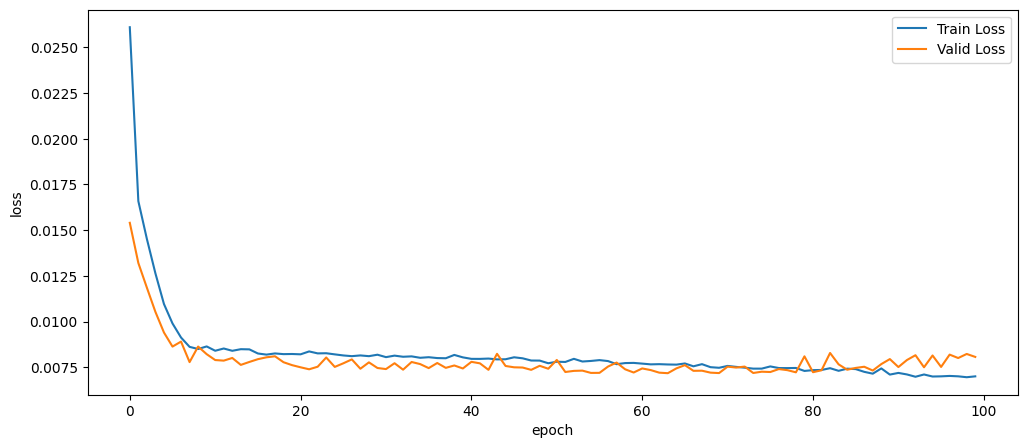

In [19]:
plt.figure(figsize = (12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

> ## 5) Model Evaluate

In [20]:
trainScore = model.evaluate(train_X, train_y, verbose = 0)
print('Train Score: ', trainScore)

testScore = model.evaluate(test_X, test_y, verbose = 0)
print('Test Score: ', testScore)

Train Score:  [0.0067615266889333725, 0.06289885193109512]
Test Score:  [0.008072325959801674, 0.0681634470820427]


## 6) Model Predict

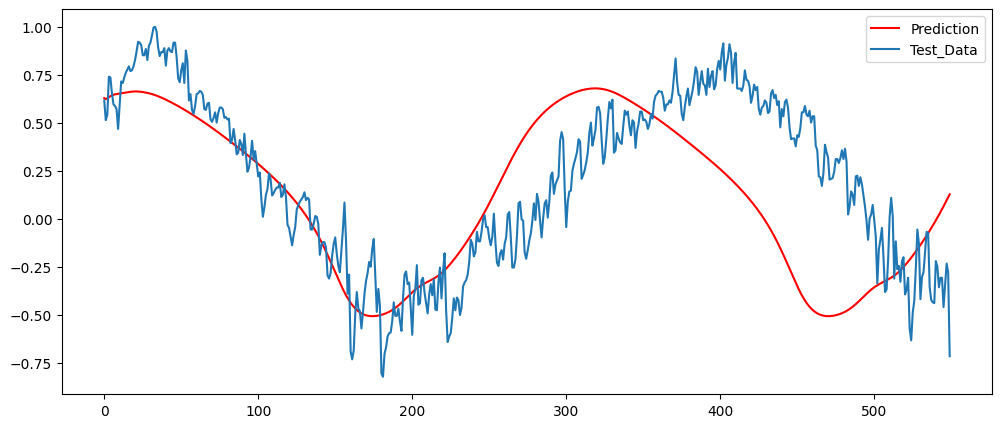

In [21]:
look_ahead = 550

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1, verbose = 0)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.legend()
plt.show()

# 5. Stacked LSTM Modeling

> ## 1) Model Define

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model2 = Sequential(name = 'Stackd_LSTM')
model2.add(LSTM(64,
               input_shape = (None, 1),
               return_sequences = True))
model2.add(LSTM(64,
               input_shape = (None, 1),
               return_sequences = False))
model2.add(Dense(1, activation = 'tanh'))

* Model Summary

In [24]:
model2.summary()

Model: "Stackd_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, None, 64)          16896     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


> ## 2) Model Compile

In [25]:
model2.compile(loss = 'mse',
              optimizer = 'adam',
              metrics = ['mae'])

> ## 3) Model Fit

* 약 10분

In [26]:
%%time

hist2 = model2.fit(train_X, train_y,
                 epochs = 100,
                 batch_size = 16,
                 validation_data = (test_X, test_y))

Epoch 1/100
149/149 [==============================] - 6s 19ms/step - loss: 0.0234 - mae: 0.1161 - val_loss: 0.0158 - val_mae: 0.0978
Epoch 2/100
149/149 [==============================] - 2s 14ms/step - loss: 0.0174 - mae: 0.1009 - val_loss: 0.0144 - val_mae: 0.0934
Epoch 3/100
149/149 [==============================] - 3s 19ms/step - loss: 0.0160 - mae: 0.0968 - val_loss: 0.0137 - val_mae: 0.0912
Epoch 4/100
149/149 [==============================] - 2s 15ms/step - loss: 0.0144 - mae: 0.0914 - val_loss: 0.0134 - val_mae: 0.0927
Epoch 5/100
149/149 [==============================] - 2s 14ms/step - loss: 0.0125 - mae: 0.0856 - val_loss: 0.0101 - val_mae: 0.0779
Epoch 6/100
149/149 [==============================] - 2s 14ms/step - loss: 0.0103 - mae: 0.0777 - val_loss: 0.0096 - val_mae: 0.0778
Epoch 7/100
149/149 [==============================] - 2s 14ms/step - loss: 0.0087 - mae: 0.0698 - val_loss: 0.0078 - val_mae: 0.0680
Epoch 8/100
149/149 [==============================] - 3s 17ms

> ## 4) 학습결과 시각화

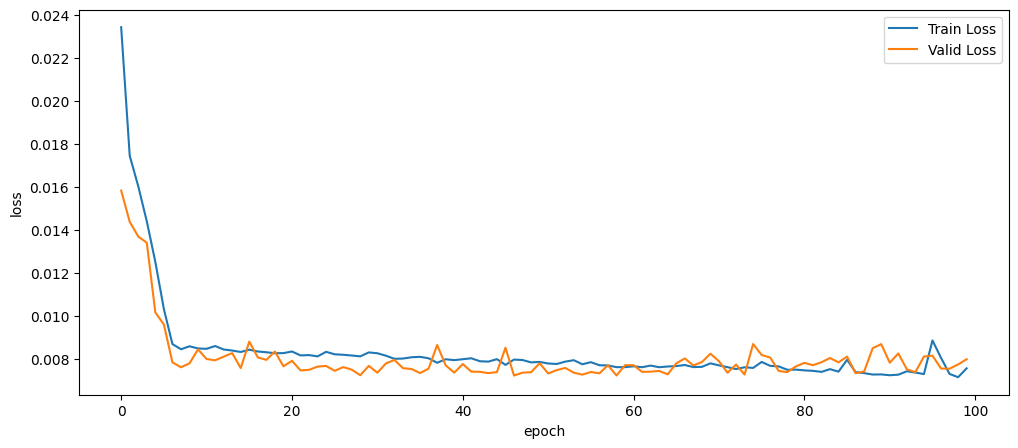

In [27]:
plt.figure(figsize = (12, 5))
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

> ## 5) Model Evaluate

In [28]:
trainScore = model2.evaluate(train_X, train_y, verbose = 0)
print('Train Score: ', trainScore)

testScore = model2.evaluate(test_X, test_y, verbose = 0)
print('Test Score: ', testScore)

Train Score:  [0.00731464521959424, 0.06431565433740616]
Test Score:  [0.007968900725245476, 0.0677737295627594]


## 6) Model Predict

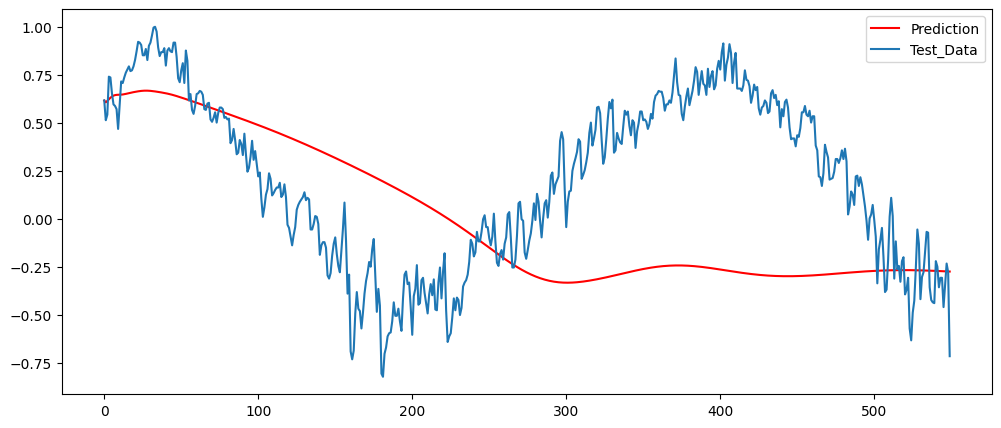

In [29]:
look_ahead = 550

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model2.predict(np.array([xhat]), batch_size = 1, verbose = 0)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.legend()
plt.show()

# 6. Gated Recurrent Unit

> ## 1) Model Define

In [30]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU

model3 = Sequential(name = 'GRU')
model3.add(GRU(64, input_shape = (None, 1)))
model3.add(Dense(1, activation = 'tanh'))

* Model Summary

In [31]:
model3.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12929 (50.50 KB)
Trainable params: 12929 (50.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


> ## 2) Model Compile

In [32]:
model3.compile(loss = 'mse',
              optimizer = 'adam',
              metrics = ['mae'])

> ## 3) Model Fit

* 약 10분

In [33]:
%%time

hist3 = model3.fit(train_X, train_y,
                 epochs = 100,
                 batch_size = 16,
                 validation_data = (test_X, test_y))

Epoch 1/100
149/149 [==============================] - 4s 11ms/step - loss: 0.0299 - mae: 0.1220 - val_loss: 0.0132 - val_mae: 0.0887
Epoch 2/100
149/149 [==============================] - 1s 9ms/step - loss: 0.0136 - mae: 0.0888 - val_loss: 0.0112 - val_mae: 0.0813
Epoch 3/100
149/149 [==============================] - 1s 9ms/step - loss: 0.0118 - mae: 0.0833 - val_loss: 0.0101 - val_mae: 0.0777
Epoch 4/100
149/149 [==============================] - 1s 9ms/step - loss: 0.0105 - mae: 0.0778 - val_loss: 0.0094 - val_mae: 0.0764
Epoch 5/100
149/149 [==============================] - 2s 11ms/step - loss: 0.0095 - mae: 0.0739 - val_loss: 0.0085 - val_mae: 0.0712
Epoch 6/100
149/149 [==============================] - 2s 10ms/step - loss: 0.0090 - mae: 0.0716 - val_loss: 0.0082 - val_mae: 0.0682
Epoch 7/100
149/149 [==============================] - 1s 8ms/step - loss: 0.0089 - mae: 0.0712 - val_loss: 0.0082 - val_mae: 0.0699
Epoch 8/100
149/149 [==============================] - 1s 9ms/step

> ## 4) 학습결과 시각화

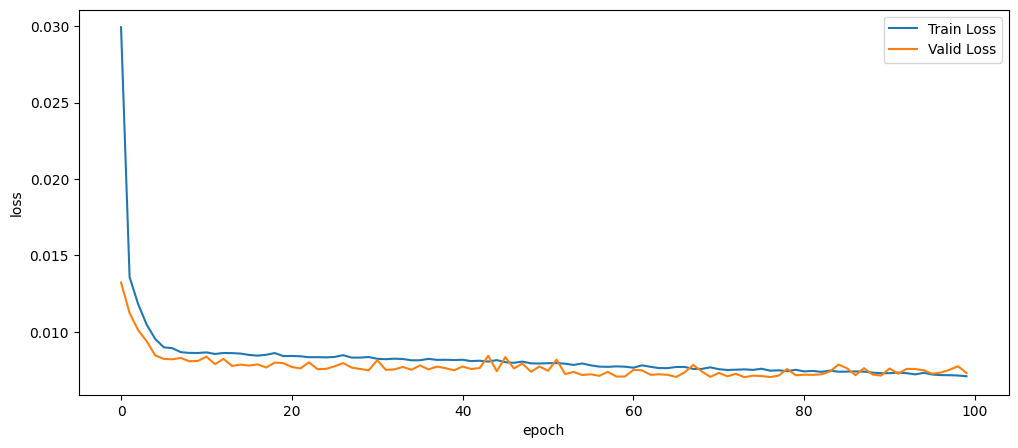

In [34]:
plt.figure(figsize = (12, 5))
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

> ## 5) Model Evaluate

In [35]:
trainScore = model3.evaluate(train_X, train_y, verbose = 0)
print('Train Score: ', trainScore)

testScore = model3.evaluate(test_X, test_y, verbose = 0)
print('Test Score: ', testScore)

Train Score:  [0.006748105399310589, 0.062238942831754684]
Test Score:  [0.007306334096938372, 0.06560850143432617]


## 6) Model Predict

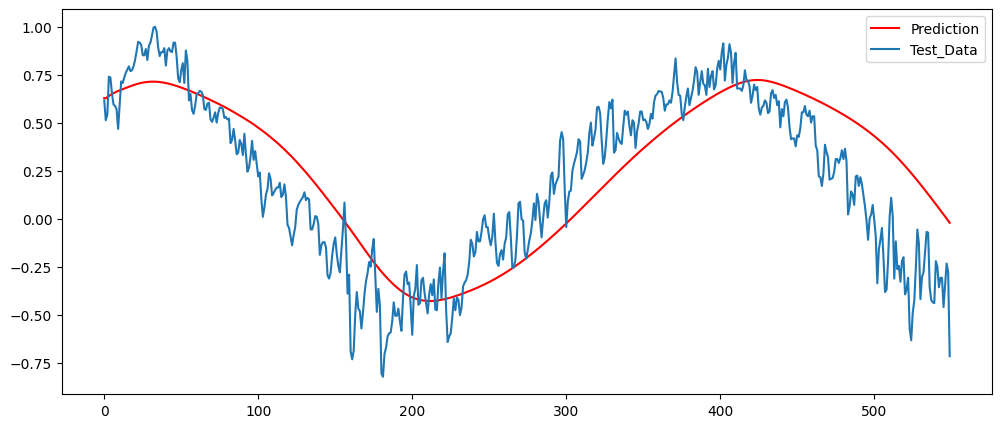

In [36]:
look_ahead = 550

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model3.predict(np.array([xhat]), batch_size = 1, verbose = 0)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.legend()
plt.show()

# 7. Bidirectional LSTM Modeling

> ## 1) Model Define

In [37]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional

model4 = Sequential(name = 'Bidirectional_LSTM')
model4.add(Bidirectional(LSTM(64,
                             input_shape = (None, 1))))
model4.add(Dense(1, activation = 'tanh'))

* Model Summary

In [43]:
model4.summary()

Model: "Bidirectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 128)               33792     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 33921 (132.50 KB)
Trainable params: 33921 (132.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


> ## 2) Model Compile

In [38]:
model4.compile(loss = 'mse',
              optimizer = 'adam',
              metrics = ['mae'])

> ## 3) Model Fit

* 약 10분

In [39]:
%%time

hist4 = model4.fit(train_X, train_y,
                 epochs = 100,
                 batch_size = 16,
                 validation_data = (test_X, test_y))

Epoch 1/100
149/149 [==============================] - 8s 21ms/step - loss: 0.0209 - mae: 0.1091 - val_loss: 0.0139 - val_mae: 0.0913
Epoch 2/100
149/149 [==============================] - 2s 14ms/step - loss: 0.0147 - mae: 0.0931 - val_loss: 0.0125 - val_mae: 0.0852
Epoch 3/100
149/149 [==============================] - 2s 14ms/step - loss: 0.0135 - mae: 0.0892 - val_loss: 0.0113 - val_mae: 0.0814
Epoch 4/100
149/149 [==============================] - 2s 15ms/step - loss: 0.0119 - mae: 0.0833 - val_loss: 0.0105 - val_mae: 0.0808
Epoch 5/100
149/149 [==============================] - 3s 18ms/step - loss: 0.0108 - mae: 0.0791 - val_loss: 0.0086 - val_mae: 0.0700
Epoch 6/100
149/149 [==============================] - 2s 14ms/step - loss: 0.0090 - mae: 0.0726 - val_loss: 0.0078 - val_mae: 0.0665
Epoch 7/100
149/149 [==============================] - 2s 14ms/step - loss: 0.0086 - mae: 0.0704 - val_loss: 0.0082 - val_mae: 0.0696
Epoch 8/100
149/149 [==============================] - 2s 15ms

> ## 4) 학습결과 시각화

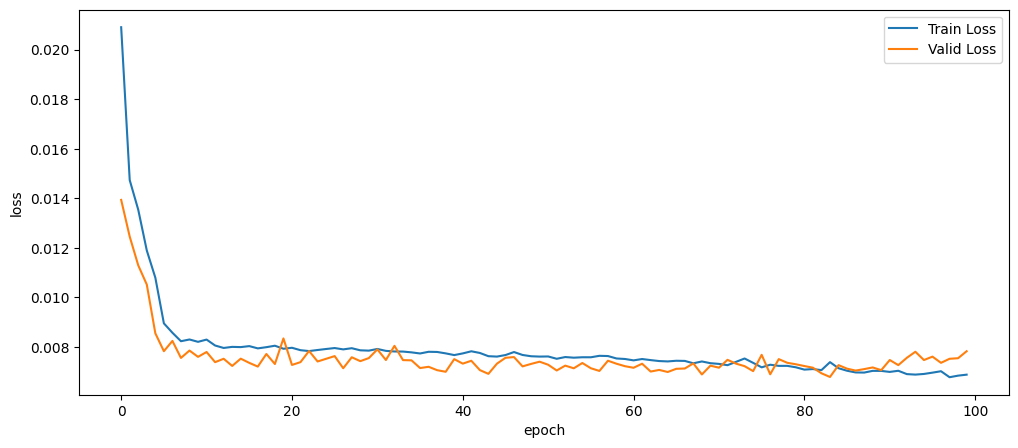

In [40]:
plt.figure(figsize = (12, 5))
plt.plot(hist4.history['loss'])
plt.plot(hist4.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

> ## 5) Model Evaluate

In [41]:
trainScore = model4.evaluate(train_X, train_y, verbose = 0)
print('Train Score: ', trainScore)

testScore = model4.evaluate(test_X, test_y, verbose = 0)
print('Test Score: ', testScore)

Train Score:  [0.006951510440558195, 0.06345026195049286]
Test Score:  [0.007826598361134529, 0.06688188016414642]


## 6) Model Predict

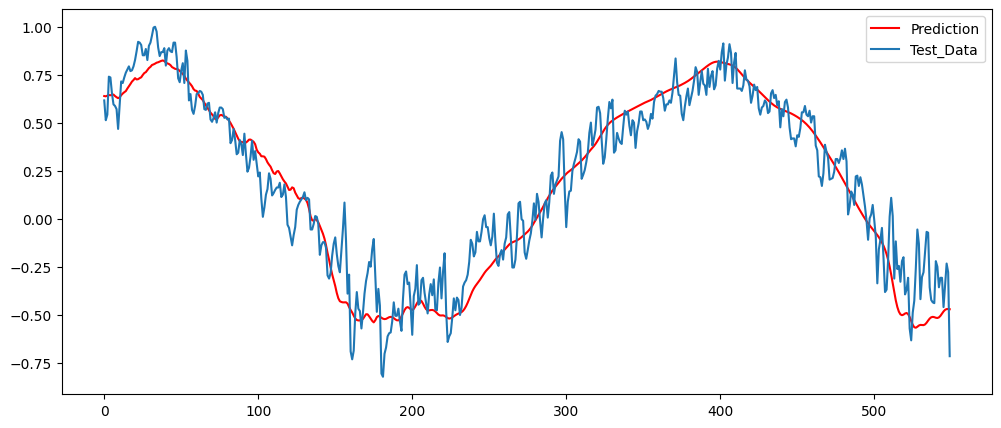

In [42]:
look_ahead = 550

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model4.predict(np.array([xhat]), batch_size = 1, verbose = 0)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.legend()
plt.show()

# The End